This notebook used flight delay data on 2015 Jun. We created a graph using airports as nodes, and distance between airports as weights. Calculating the eigenvalues and plotting them, we noticed a jump from 4-th to 5-th eigenvalue, which implies 5 clusters in our data. So we used top 5 eigenvectors as features and did the k-means (k=5). The result was both shown spectrally and geographically. And we can see that there is connection between airport location (whether they are in Eastern US or Western US) and delay time.

In [535]:
!pip install nbmerge

  Running setup.py bdist_wheel for nbmerge ... done
  Stored in directory: /Users/yan/Library/Caches/pip/wheels/93/0c/59/ac91905c182ce43c4f39a50b5381c9485049cfe913237872ff
Successfully built nbmerge
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [54]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [137]:
flights = pd.read_csv('flights_new.csv')
airports = pd.read_csv('airports.csv')

In [384]:
pos_dict = {}
for i in range(len(airports)):
    pos_dict[airports.IATA_CODE[i]] = airports.LONGITUDE[i],airports.LATITUDE[i]

In [10]:
df = flights[['MONTH','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_TIME','DISTANCE']]

In [416]:
df1 = df.loc[df.MONTH==6].copy()
df2 = df1.groupby(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'])['DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_TIME','DISTANCE'].mean()
df2.reset_index(inplace=True)

df2['weight'] = df2.DISTANCE
df2.weight = df2.weight.clip_upper(2000)
df2.weight=(df2.weight-df2.weight.min())/(df2.weight.max()-df2.weight.min())

delta = 1
df2.weight = np.exp(-np.square(df2.weight)/delta)



In [417]:
G=nx.from_pandas_edgelist(df2, 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', edge_attr='weight')

In [517]:
node_col = G.nodes
label_df = pd.DataFrame(columns=node_col).append(df2.groupby(['ORIGIN_AIRPORT'])['DEPARTURE_DELAY','ARRIVAL_DELAY'].mean().T,sort=False).T
label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY-10
label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY.clip_upper(-1*np.min(label_df.ARRIVAL_DELAY))
label_df.head()

,DEPARTURE_DELAY,ARRIVAL_DELAY
ABE,12.595216,3.050936
ATL,14.348884,-1.562118
DTW,12.056992,-2.587865
ORD,19.658550,6.241072
ABI,10.509709,0.538835


In [518]:
label_geo_df = pd.merge(label_df,airports.set_index('IATA_CODE'),left_index=True,right_index=True)

In [498]:
L = nx.normalized_laplacian_matrix(G)
e, U = sparse.linalg.eigsh(L, k=10, which='BE')

Text(0.5,1,'top 10 eigenvalue')

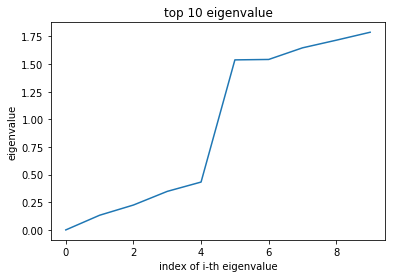

In [534]:
plt.plot(e)
plt.xlabel('index of i-th eigenvalue')
plt.ylabel('eigenvalue')
plt.title('top 10 eigenvalue')

In [501]:
X = U[:,0:5]

k_means = KMeans(init='k-means++', n_clusters=5, n_init=10)
k_means.fit(X)

k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

(-0.02, 0.03)

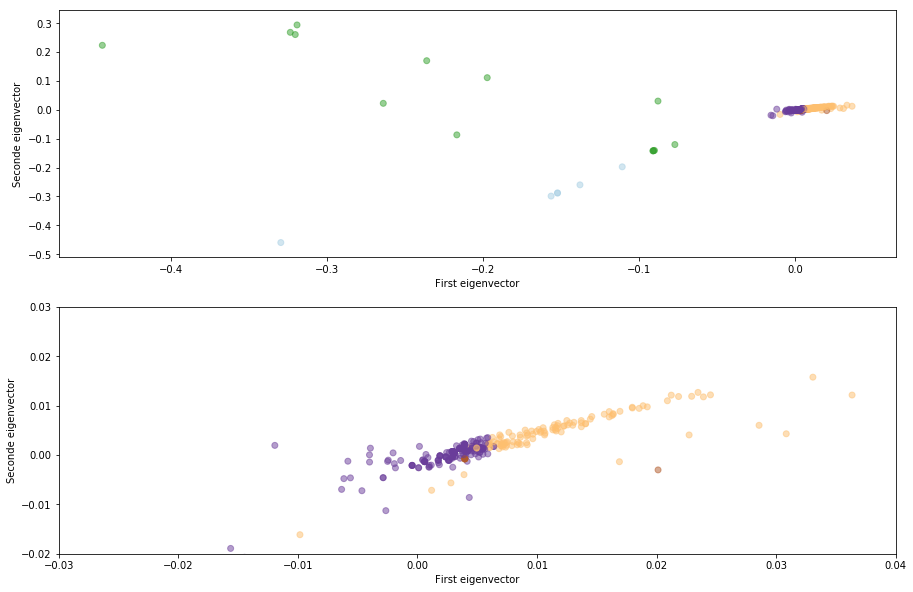

In [511]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.5,cmap='Paired')
ax[0].set_xlabel('First eigenvector')
ax[0].set_ylabel('Seconde eigenvector')
#plt.colorbar()
ax[1].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.5,cmap='Paired')
ax[1].set_xlabel('First eigenvector')
ax[1].set_ylabel('Seconde eigenvector')
ax[1].set_xlim(-0.03,0.04)
ax[1].set_ylim(-0.02,0.03)


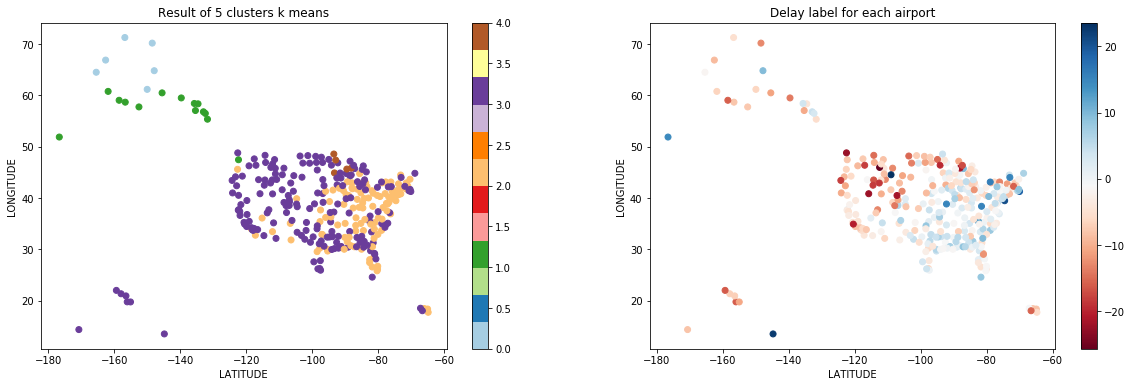

In [532]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
im0 = ax[0].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,c=k_means_labels,cmap='Paired')
ax[0].set_xlabel('LATITUDE')
ax[0].set_ylabel('LONGITUDE')
ax[0].set_title('Result of 5 clusters k means')
#plt.colorbar()

label = label_geo_df.ARRIVAL_DELAY.copy()
label[label<=0] = -1
label[label>0] = 1
# ax[1].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,c=label,cmap='Paired')
im1 = ax[1].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,c=label_geo_df.ARRIVAL_DELAY,cmap='RdBu')

ax[1].set_xlabel('LATITUDE')
ax[1].set_ylabel('LONGITUDE')
ax[1].set_title('Delay time(minutes) for each airport')

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
